In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost.callback import LearningRateScheduler

#from indicators import set_indicators
from dataPreprocess import preprocess

In [10]:
# 1. 加载数据并添加技术指标
print("加载数据...")
data = pd.read_csv("Russell1000AndSP500_withIndicators.csv")
data = preprocess(data)

# 2. 保留时序顺序（真实场景中不打乱）
# 如果需要随机打乱，请取消下面两行注释
# data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 3. 定义特征列
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'RSI', 'WR', 'BB_lower', 'BB_middle', 'BB_upper',
    'MA5', 'MA10', 'MA20', 'MA50', 'MACD', 'Signal', 'Histogram',
    '%K', '%D', '%J', 'ATR', 'OBV', 'ADX', 'DMP', 'DMN',
    'StochRSI_k', 'StochRSI_d', 'CCI'
] + [f'lag_{i}' for i in range(1, 16)]

# 去除缺失数据
data.dropna(subset=features + ['pct_chg'], inplace=True)

# 4. 特征归一化（可选）
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 5. 构造训练集和测试集（保留时序）
X = data[features].astype(np.float32)
y = data['pct_chg'].astype(np.float32)

split = int(0.8 * len(data))  # 80%训练，20%测试
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 创建 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

加载数据...


In [11]:
# 6. 定义模型参数
params = {
    "max_depth": 4,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eval_metric": "rmse",
    "reg_alpha": 1.7,
    "reg_lambda": 5.0,
    "seed": 42,
    "subsample": 0.9,
    "colsample_bytree": 0.9
}

In [72]:
# 7. 定义学习率衰减函数
# 初始学习率设为 0.4，每 5 轮乘以 0.98 衰减一次
def lr_decay(epoch):
    if epoch < 150:
        lr = 0.55 * (0.98 ** (epoch // 8))
    elif epoch < 800:
        lr = 0.5 * (0.98 ** (epoch % 6))
    elif epoch < 1600:
        lr = 0.4 * (0.98 ** (epoch % 4))
    else:
        lr = 0.1  * (0.98 ** (epoch % 8))
    return lr

开始训练...
[0]	train-rmse:22.62595	test-rmse:7.26657
[1]	train-rmse:19.19709	test-rmse:7.00310
[2]	train-rmse:16.26482	test-rmse:6.88156
[3]	train-rmse:13.79374	test-rmse:6.79564
[4]	train-rmse:13.15841	test-rmse:6.70998
[5]	train-rmse:13.02389	test-rmse:6.74460
[6]	train-rmse:12.25363	test-rmse:6.31701
[7]	train-rmse:11.80633	test-rmse:6.21234
[8]	train-rmse:10.09777	test-rmse:6.24760
[9]	train-rmse:8.84990	test-rmse:6.20629
[10]	train-rmse:8.43309	test-rmse:6.19868
[11]	train-rmse:8.22548	test-rmse:6.19143
[12]	train-rmse:8.21856	test-rmse:6.17887
[13]	train-rmse:7.51556	test-rmse:6.17472
[14]	train-rmse:7.14117	test-rmse:6.14879
[15]	train-rmse:6.67076	test-rmse:5.76804
[16]	train-rmse:6.37786	test-rmse:5.37272
[17]	train-rmse:6.13904	test-rmse:5.19496
[18]	train-rmse:5.72768	test-rmse:5.18872
[19]	train-rmse:5.51847	test-rmse:4.72223
[20]	train-rmse:5.25674	test-rmse:4.52650
[21]	train-rmse:5.24365	test-rmse:4.50653
[22]	train-rmse:5.10074	test-rmse:4.19229
[23]	train-rmse:5.09738	tes

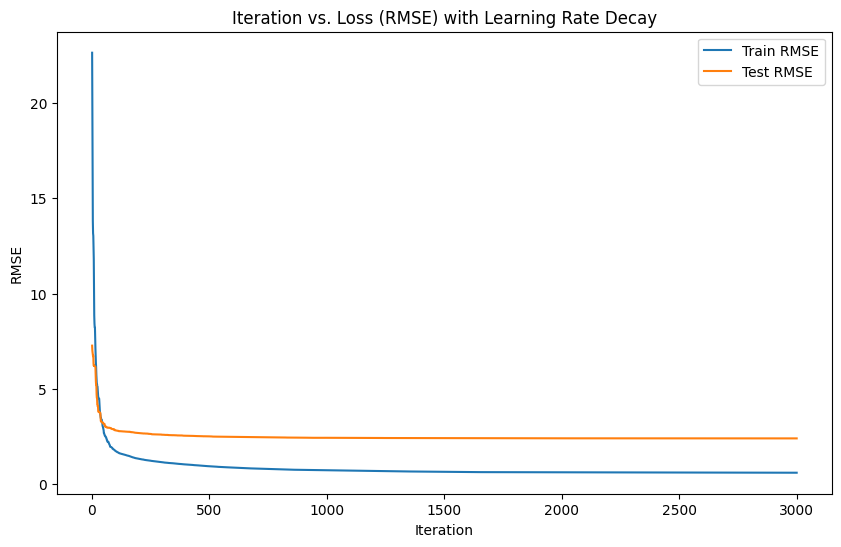

Test MSE: 5.7757
Test MAE: 0.4745


In [73]:
# 8. 训练模型
evals = [(dtrain, "train"), (dtest, "test")]
evals_result = {}  # 用于存储评估结果
print("开始训练...")
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=3000,
    evals=evals,
    evals_result=evals_result,  # 传入一个空字典来记录评估结果
    callbacks=[LearningRateScheduler(lr_decay)]
)

# 9. 绘制损失曲线，直接使用 evals_result 字典
train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']
epochs = list(range(1, len(train_rmse) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Train RMSE')
plt.plot(epochs, test_rmse, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Iteration vs. Loss (RMSE) with Learning Rate Decay')
plt.legend()
plt.show()

# 10. 模型预测与评估
y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

In [29]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [74]:
bst.save_model("stock_Predict_Model.xgb")

C:\Users\Baimin\AppData\Local\Temp\ipykernel_17220\2671758659.py:1: UserWarning: [20:37:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  bst.save_model("stock_Predict_Model.xgb")
